# Phone Company Text Tagging (pt-br)

Just some fun with a random text classification problem.

Dataset source: https://www.kaggle.com/samuelhei/dataset-for-text-tagging-phone-company-ptbr/version/2

In [1]:
# Comando para plotar gráficos no próprio notebook.
%matplotlib inline

In [2]:
import os  # Manipulação de arquivos e diretórios.
import re  # Expressões regulares.
import random  # Geração de números aleatórios.
import itertools  # Funções combinatoriais.
import copy  # Cópia profunda de objetos.
import unicodedata  # Processamento de caracteres Unicode.
import operator  # Sobrecarga de operadores.
from functools import reduce  # Função reduce.
import pickle  # Persistência de objetos.
import numpy as np  # Numpy.
import pandas as pd  # Pandas.
import matplotlib.pyplot as plt  # Pyplot.
import wordcloud as wc  # Geração de wordclouds.
import nltk  # Processamento de linguagem natural.
from nltk.corpus import stopwords  # Listas de stopwords.
from sklearn.preprocessing import LabelEncoder  # Codificação dos rótulos das classes.
from sklearn.preprocessing import MultiLabelBinarizer  # Codificação binária para multilabel.
from sklearn.feature_extraction.text import TfidfVectorizer  # Geração da TF-IDF.
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes multinomial.
from sklearn.naive_bayes import ComplementNB  # Naive Bayes para datasets desbalanceados.
from sklearn.pipeline import Pipeline  # Montagem de pipeline.
from sklearn.model_selection import train_test_split  # Particionamento do dataset.
from sklearn.model_selection import StratifiedKFold  # K-fold cross validation estratificada.
from sklearn.model_selection import GridSearchCV  # Otimização de hiperparâmetros.
from sklearn.metrics import confusion_matrix  # Matriz de confusão.
from sklearn.metrics import roc_curve, auc, roc_auc_score  # Curva ROC e AUC-score.
from sklearn.metrics import precision_recall_curve  # Curva PR.
from sklearn.metrics import classification_report  # Outras métricas de avaliação.

In [3]:
# Define a semente para a geração de números pseudo-aleatórios
# para tornar os resultados replicáveis.
random.seed(42)
np.random.seed(42)

In [4]:
# Define o diretório do dataset.
data_dir = os.path.abspath(os.path.join('..', 'data'))
data_dir

'/home/chvillap/Workspace/phonecompany/data'

In [5]:
# Define o diretório dos modelos salvos.
models_dir = os.path.abspath(os.path.join('..', 'models'))
models_dir

'/home/chvillap/Workspace/phonecompany/models'

In [6]:
# Carrega o dataset e exibe alguns registros.
df = pd.read_csv(os.path.join(data_dir, 'tagging_3.csv'))
df.head(10)

,frase,tag
0,é consertar o meu telefone,reparar-linha
1,como faço para ter a linha controle oitenta,comprar-linha
2,não estou conseguindo fazer uma ligação,reparar-linha
3,é adquirir uma linha cadeada,comprar-linha
4,não o problema é o chiado no meu telefone,reparar-linha
5,quero saber um problema com uma linha,reparar-linha
6,é fazer o reparo da minha linha telefônica,reparar-linha
7,como faço para consertar o telefone,reparar-linha
8,pedir transferência de endereço,mudar-endereco
9,eu quero saber se este telefone está com defei...,reparar-linha


In [7]:
# Obtém o número total de observações, de variáveis e de classes.
num_obs, num_var = df.shape
num_class = df['tag'].nunique()
num_obs, num_var, num_class

(6958, 2, 7)

In [8]:
# Obtém os rótulos das classes.
class_labels = np.unique(df['tag']).tolist()
class_labels

['cancelar-conta',
 'cancelar-servicos',
 'comprar-linha',
 'mudar-endereco',
 'pagar-conta',
 'reparar-linha',
 'vago-visitaTecnica']

In [9]:
# Particiona o dataset em amostras de treino e teste.
# Obs: a amostragem é estratificada em função das classes!
X_train, X_test, y_train, y_test = train_test_split(
    df['frase'], df['tag'], test_size=0.2, stratify=df['tag'], random_state=42)
X_train.size, X_test.size

(5566, 1392)

In [10]:
# Calcula e compara a distribuição das classes em cada partição.
y_train_distr = y_train.value_counts() / y_train.size
y_test_distr = y_test.value_counts() / y_test.size
pd.concat((y_train_distr, y_test_distr), axis=1)

,tag,tag
reparar-linha,0.652713,0.653017
comprar-linha,0.145167,0.145115
mudar-endereco,0.062882,0.062500
pagar-conta,0.061085,0.061063
cancelar-servicos,0.042221,0.042385
cancelar-conta,0.028566,0.028736
vago-visitaTecnica,0.007366,0.007184


In [11]:
# Obtém a lista de stopwords em PT-BR.
stopwords_pt = stopwords.words('portuguese')
stopwords_pt

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [12]:
# Função que substitui caracteres com acentos.
def strip_accents(word):
    return ''.join(ch for ch in unicodedata.normalize('NFD', word)
                   if unicodedata.category(ch) != 'Mn')

In [13]:
# Inclui versões sem acento das stopwords com acentos.
stopwords_pt_accent = [word for word in stopwords_pt if not re.match('^[a-zA-Z_]+$', word)]
stopwords_pt_noaccent = [strip_accents(word) for word in stopwords_pt_accent]
stopwords_pt.extend(stopwords_pt_noaccent)
stopwords_pt

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [14]:
# Função de coloração com tons aleatórios de azul.
def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    r, g, b = random.randint(0, 63), random.randint(0, 127), random.randint(64, 255)
    return "rgb({}, {}, {})".format(r, g, b)

# Função de coloração com tons aleatórios de vermelho.
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    r, g, b = random.randint(64, 255), random.randint(0, 127), random.randint(0, 63)
    return "rgb({}, {}, {})".format(r, g, b)

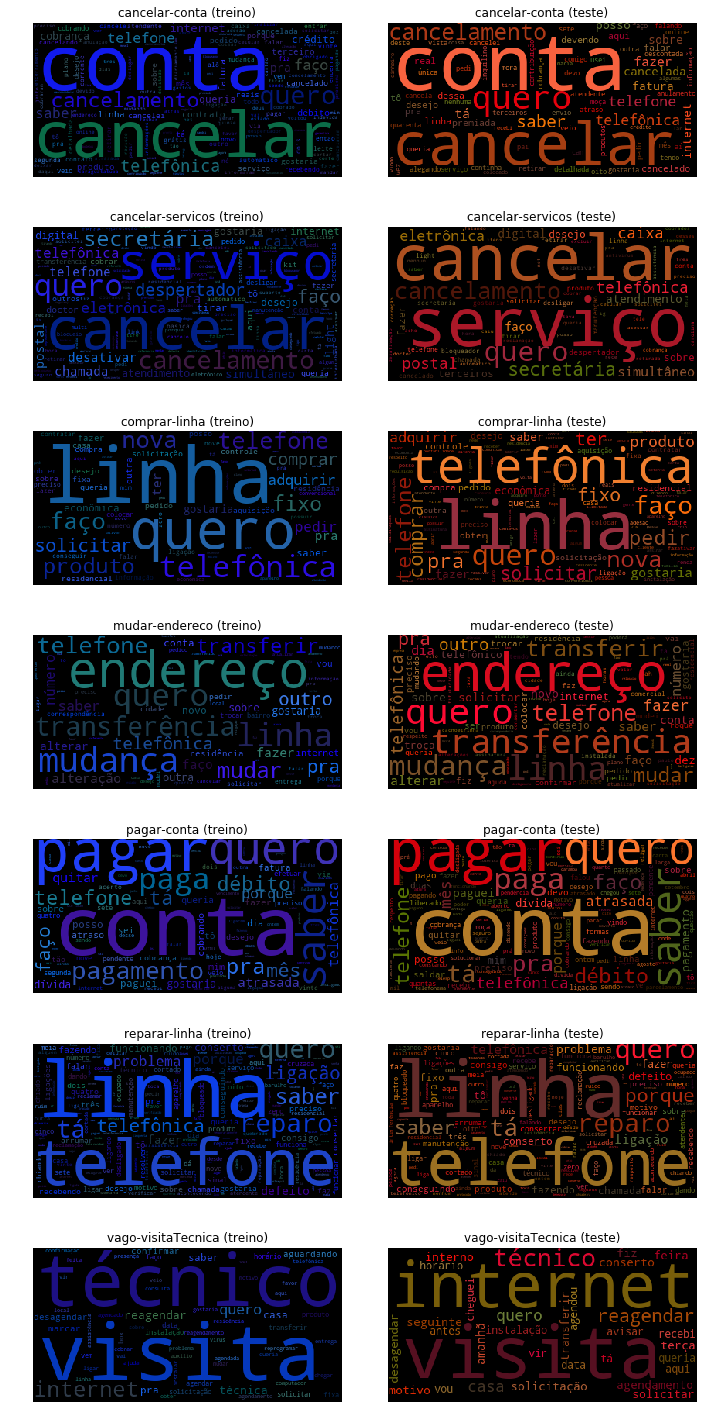

In [15]:
# Gera wordclouds com os conjuntos de treino e teste para cada classe.
fig, ax = plt.subplots(num_class, 2)
fig.set_figwidth(10)
fig.set_figheight(20)
for i in range(num_class):
    c = class_labels[i]
    text_train = X_train.loc[y_train == c].str.cat(sep='\n')
    text_test = X_test.loc[y_test == c].str.cat(sep='\n')
    wc_train = wc.WordCloud(stopwords=stopwords_pt,
                            collocations=False,
                            color_func=blue_color_func,
                            random_state=42).generate(text_train)
    wc_test = wc.WordCloud(stopwords=stopwords_pt,
                           collocations=False,
                           color_func=red_color_func,
                           random_state=42).generate(text_test)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 0].set_title('{} (treino)'.format(c))
    ax[i, 1].set_title('{} (teste)'.format(c))
    ax[i, 0].imshow(wc_train)
    ax[i, 1].imshow(wc_test)
plt.tight_layout()

In [16]:
# Faz backup da representação original das classes.
y_train_backup = y_train.copy()
y_test_backup = y_test.copy()

In [17]:
# Codifica as classes em números.
encoder = LabelEncoder().fit(y_train)
y_train = pd.Series(encoder.transform(y_train))
y_test = pd.Series(encoder.transform(y_test))

In [18]:
# Faz a codificação binária para multilabel.
y_train = y_train.apply(lambda y: [y])
y_test = y_test.apply(lambda y: [y])
binarizer = MultiLabelBinarizer().fit(y_train)
y_train = binarizer.transform(y_train)
y_test = binarizer.transform(y_test)

In [19]:
# Define o pipeline base que será seguido para todas as classes.
base_tfidf = TfidfVectorizer(
    encoding='utf-8',
    lowercase=True,
    tokenizer=None,
    stop_words=stopwords_pt,
    max_df=0.9,
    min_df=0.005,
    binary=False,
    use_idf=True,
    smooth_idf=True)
base_clf = MultinomialNB(
    class_prior=None)
base_pipeline = Pipeline(steps=(
    ('tfidf', base_tfidf),
    ('clf', base_clf)))
base_pipeline

Pipeline(memory=None,
     steps=(('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.005,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=T...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))))

In [20]:
# Replica o pipeline base para ser um para cada classe.
pipeline_list = [copy.deepcopy(base_pipeline)] * num_class
len(pipeline_list)

7

In [21]:
# Função para montar o plano de busca dos hiperparâmetros ótimos
# usando grid search e cross validation.
# Obs: note que ao incluir o pré-processamento no pipeline evitamos
# data leakage entre as partições da cross validation.
def build_gscv(pipeline):
    return GridSearchCV(estimator=pipeline,
                        param_grid={
                            'tfidf__strip_accents': [None, 'unicode'],
                            'tfidf__ngram_range': [(1,2), (1,3), (2,2), (2,3), (3,3)],
                            'tfidf__sublinear_tf': [False, True],
                            'clf__alpha': [1e-10, 1.0],
                        },
                        cv=StratifiedKFold(5, random_state=42),
                        scoring='f1_weighted',
                        verbose=1,
                        n_jobs=-1)

In [22]:
# Associa cada processo ao rótulo de sua respectiva classe.
gscv_list = [build_gscv(pipeline) for pipeline in pipeline_list]
gscv_dict = {k:v for k, v in zip(class_labels, gscv_list)}
gscv_dict

{'cancelar-conta': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
        error_score='raise-deprecating',
        estimator=Pipeline(memory=None,
      steps=(('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=0.9, max_features=None, min_df=0.005,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=T...rue,
         vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)))),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'tfidf__strip_accents': [None, 'unicode'], 'tfidf__ngram_range': [(1, 2), (1, 3), (2, 2), (2, 3), (3, 3)], 'tfidf__sublinear_tf': [False, True], 'clf__alpha': [1e-10, 1.0]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring='f1_weighted', verbose=1),
 'cancelar-servicos': GridSearchCV(cv=StratifiedKF

In [23]:
# Treina os classificadores encontrando a melhor combinação de
# hiperparâmetros para cada.
for label, gscv in gscv_dict.items():
    print('=====================================================')
    print('Treinando classificador para "{}"'.format(label))
    j = encoder.transform([label])[0]
    gscv.fit(X_train, y_train[:, j])

Treinando classificador para "cancelar-conta"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Treinando classificador para "cancelar-servicos"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   35.9s finished


Treinando classificador para "comprar-linha"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   35.8s finished


Treinando classificador para "mudar-endereco"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Treinando classificador para "pagar-conta"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   31.0s finished


Treinando classificador para "reparar-linha"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   33.4s finished


Treinando classificador para "vago-visitaTecnica"
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.5s finished


In [24]:
# Exibe os melhores scores e hiperparâmetros de cada classificador.
for label, gscv in gscv_dict.items():
    print('{} ==> score: {}; params: {}'.format(label, gscv.best_score_, gscv.best_params_))

cancelar-conta ==> score: 0.9829632319555404; params: {'clf__alpha': 1.0, 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': None, 'tfidf__sublinear_tf': True}
cancelar-servicos ==> score: 0.9835779111076978; params: {'clf__alpha': 1e-10, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode', 'tfidf__sublinear_tf': False}
comprar-linha ==> score: 0.9693468054107435; params: {'clf__alpha': 1e-10, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode', 'tfidf__sublinear_tf': True}
mudar-endereco ==> score: 0.9967428920920077; params: {'clf__alpha': 1.0, 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': None, 'tfidf__sublinear_tf': False}
pagar-conta ==> score: 0.9863867316072494; params: {'clf__alpha': 1.0, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode', 'tfidf__sublinear_tf': True}
reparar-linha ==> score: 0.9599815473282618; params: {'clf__alpha': 1e-10, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode', 'tfidf__sublinear_tf': Tr

In [25]:
# Computa as distribuições dos n-gramas de cada classificador
# pelas suas respectivas classes.
ngram_props = {}
for label, gscv in gscv_dict.items():
    j = encoder.transform([label])[0]
    tfidf = gscv.best_estimator_.named_steps['tfidf']
    ngram_props[label] = np.empty((len(tfidf.vocabulary_),))
    X_train_tfidf = tfidf.transform(X_train)
    for ngram, ind_ngram in tfidf.vocabulary_.items():
        ind_obs = np.where(X_train_tfidf[:, ind_ngram].todense() != 0)[0]
        ind_obs_1s = np.where(y_train[ind_obs, j] == 1)[0]
        ngram_props[label][ind_ngram] = ind_obs_1s.size / ind_obs.size
ngram_props

{'cancelar-conta': array([0.        , 0.        , 0.        , 0.        , 0.01123596,
        0.        , 0.        , 0.        , 0.05405405, 0.        ,
        0.        , 0.40229885, 0.4092827 , 0.95384615, 0.02631579,
        0.        , 0.00934579, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.32731959, 0.        ,
        0.57575758, 0.07894737, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01714286,
        0.        , 0.        , 0.02857143, 0.02941176, 0.        ,
        0.10344828, 0.        , 0.00324675, 0.01639344, 0.        ,
        0.02702703, 0.        , 0.        , 0.        , 0.        ,
        0.00554017, 0.        , 0.        , 0.        , 0.05211726,
        0.03797468, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        

In [26]:
# Função que plota os n-gramas que compõem o vocabulário de um
# classificador e como as classes se distribuem proporcionalmente
# em função deles.
def plot_ngram_props(ax, label, vocab, props, num_samples=50):
    xticklabels = [None] * len(vocab)
    for ngram, j in vocab.items():
        xticklabels[j] = ngram
    ind_sort = np.argsort(props)
    props = props[ind_sort]
    props = np.concatenate((props[:num_samples], props[-num_samples:]))
    xticklabels = [xticklabels[i] for i in ind_sort]
    xticklabels = xticklabels[:num_samples] + xticklabels[-num_samples:]
    ax.bar(range(props.size), props)
    ax.bar(range(props.size), props - 1.0, color='salmon')
    ax.set_xticks(range(props.size))
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_title(label)
    ax.set_ylabel('Proportion')

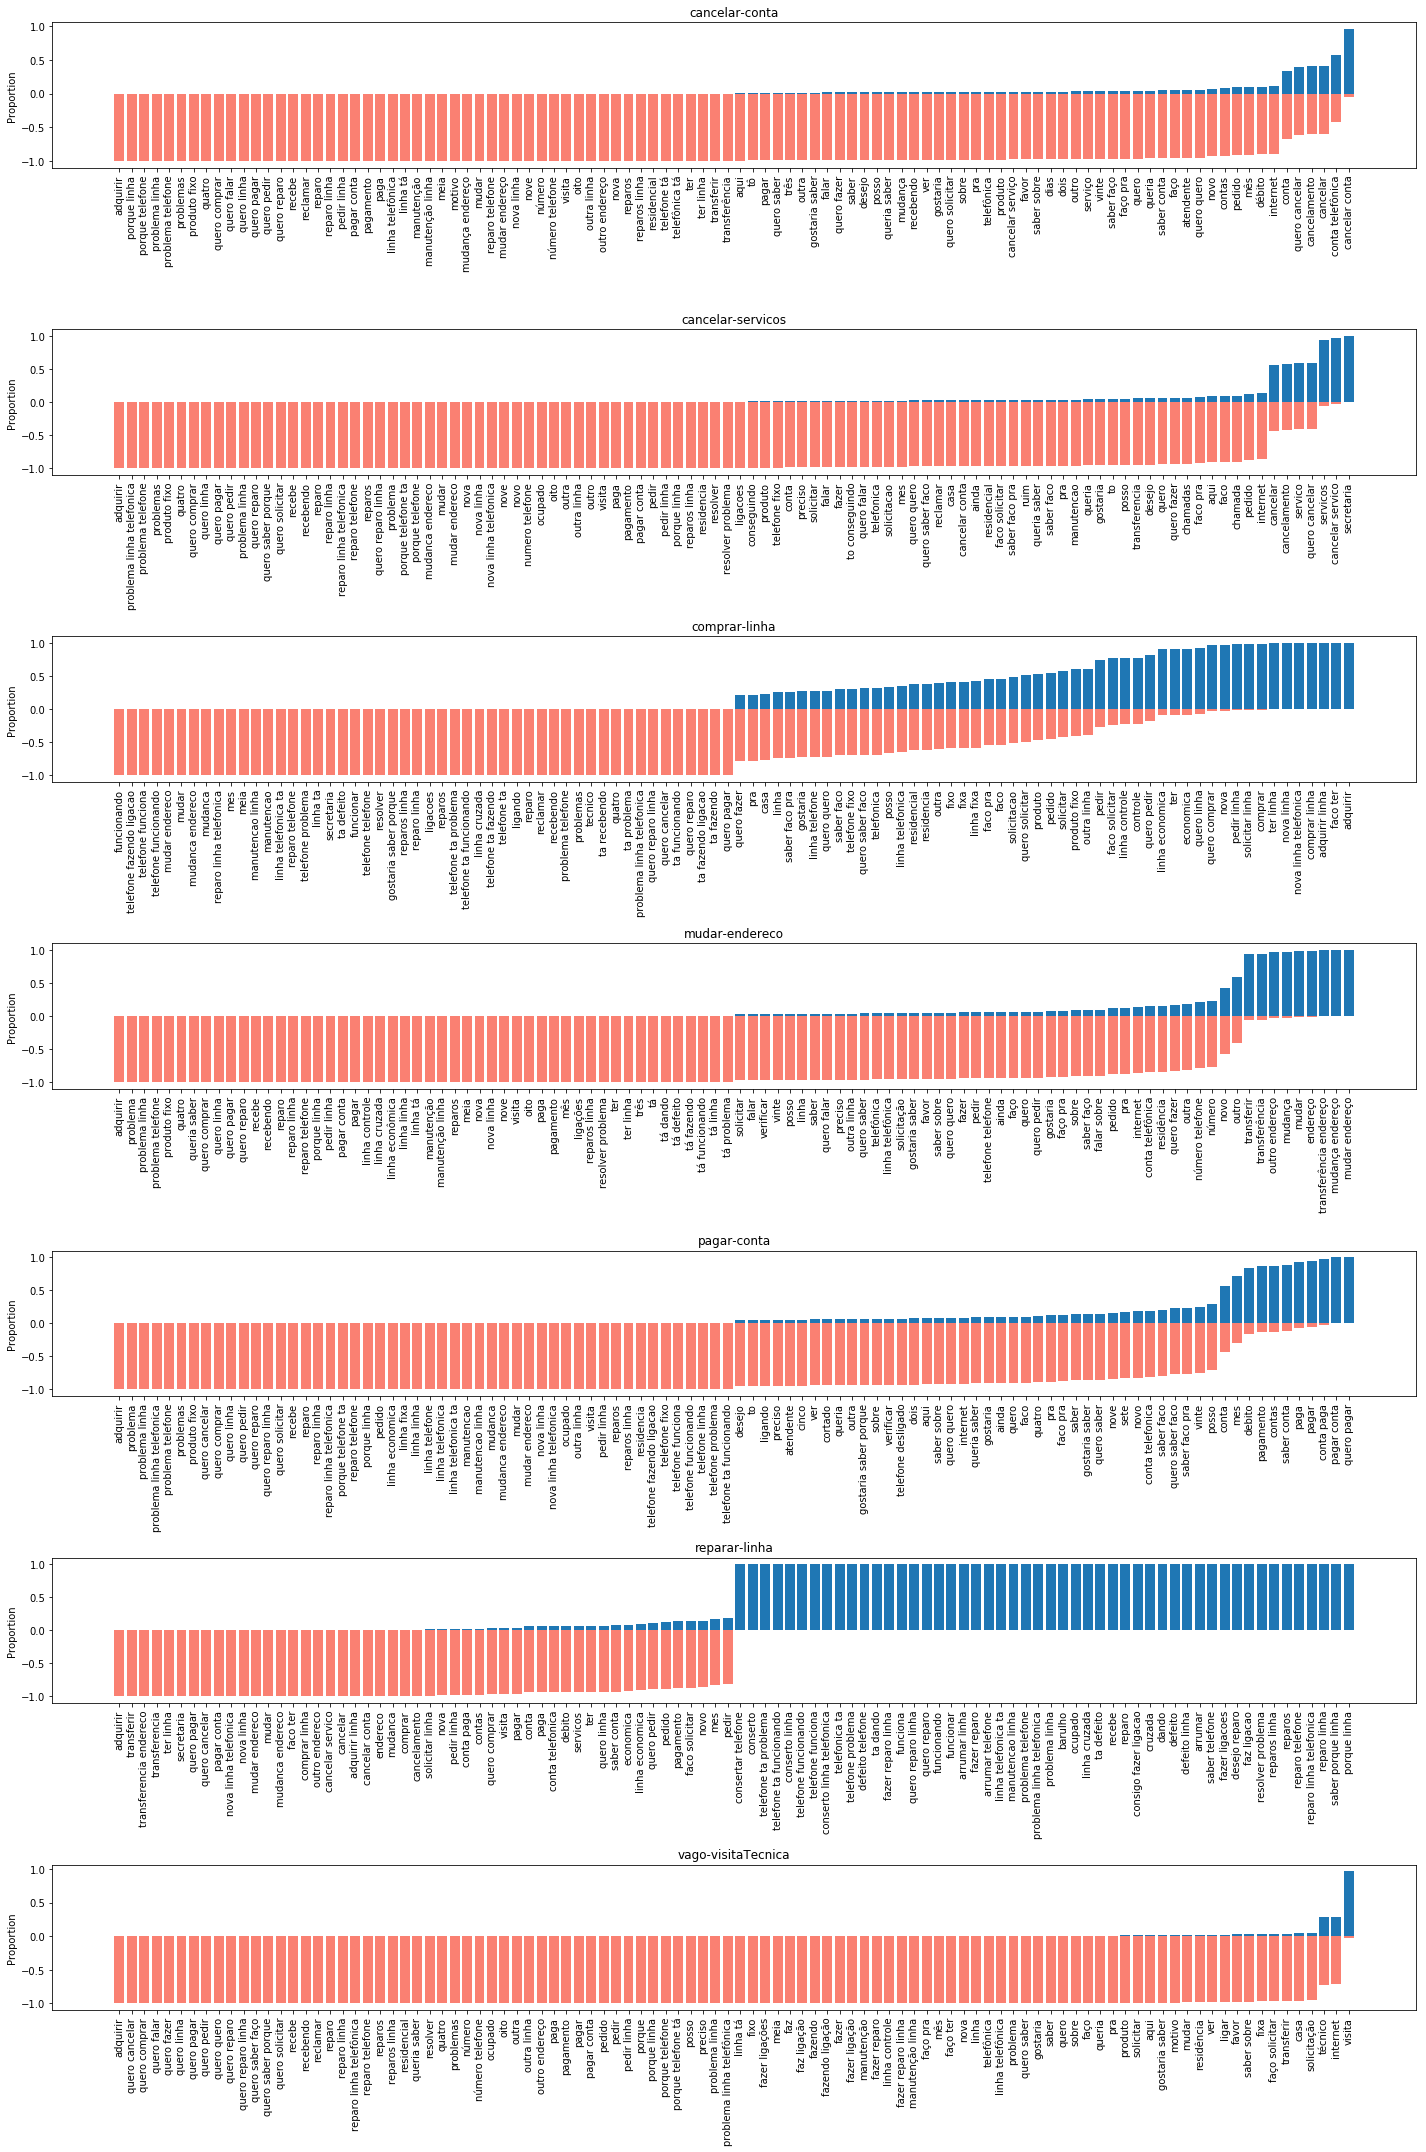

In [27]:
# Plota as distribuições dos n-gramas de cada classificador.
fig, ax = plt.subplots(num_class, 1)
fig.set_figwidth(20)
fig.set_figheight(30)
for label, gscv in gscv_dict.items():
    j = encoder.transform([label])[0]
    vocab = gscv.best_estimator_.named_steps['tfidf'].vocabulary_
    plot_ngram_props(ax[j], label, vocab, ngram_props[label])
plt.tight_layout()

In [28]:
# Função que plota as verossimilhanças P(x_i | y) dos principais
# n-gramas para uma determinada classe.
def plot_ngram_likelihoods(ax, label, vocab, log_probas, num_samples=25):
    yticklabels = [None] * len(vocab)
    for ngram, j in vocab.items():
        yticklabels[j] = ngram
    ind_sort = np.argsort(log_probas)
    log_probas = log_probas[ind_sort]
    log_probas = log_probas[-num_samples:]
    yticklabels = [yticklabels[i] for i in ind_sort]
    yticklabels = yticklabels[-num_samples:]
    ax.barh(range(log_probas.size), np.exp(log_probas))
    ax.set_yticks(range(log_probas.size))
    ax.set_yticklabels(yticklabels)
    ax.set_title(label)
    ax.set_xlabel('P(x_i | y)')

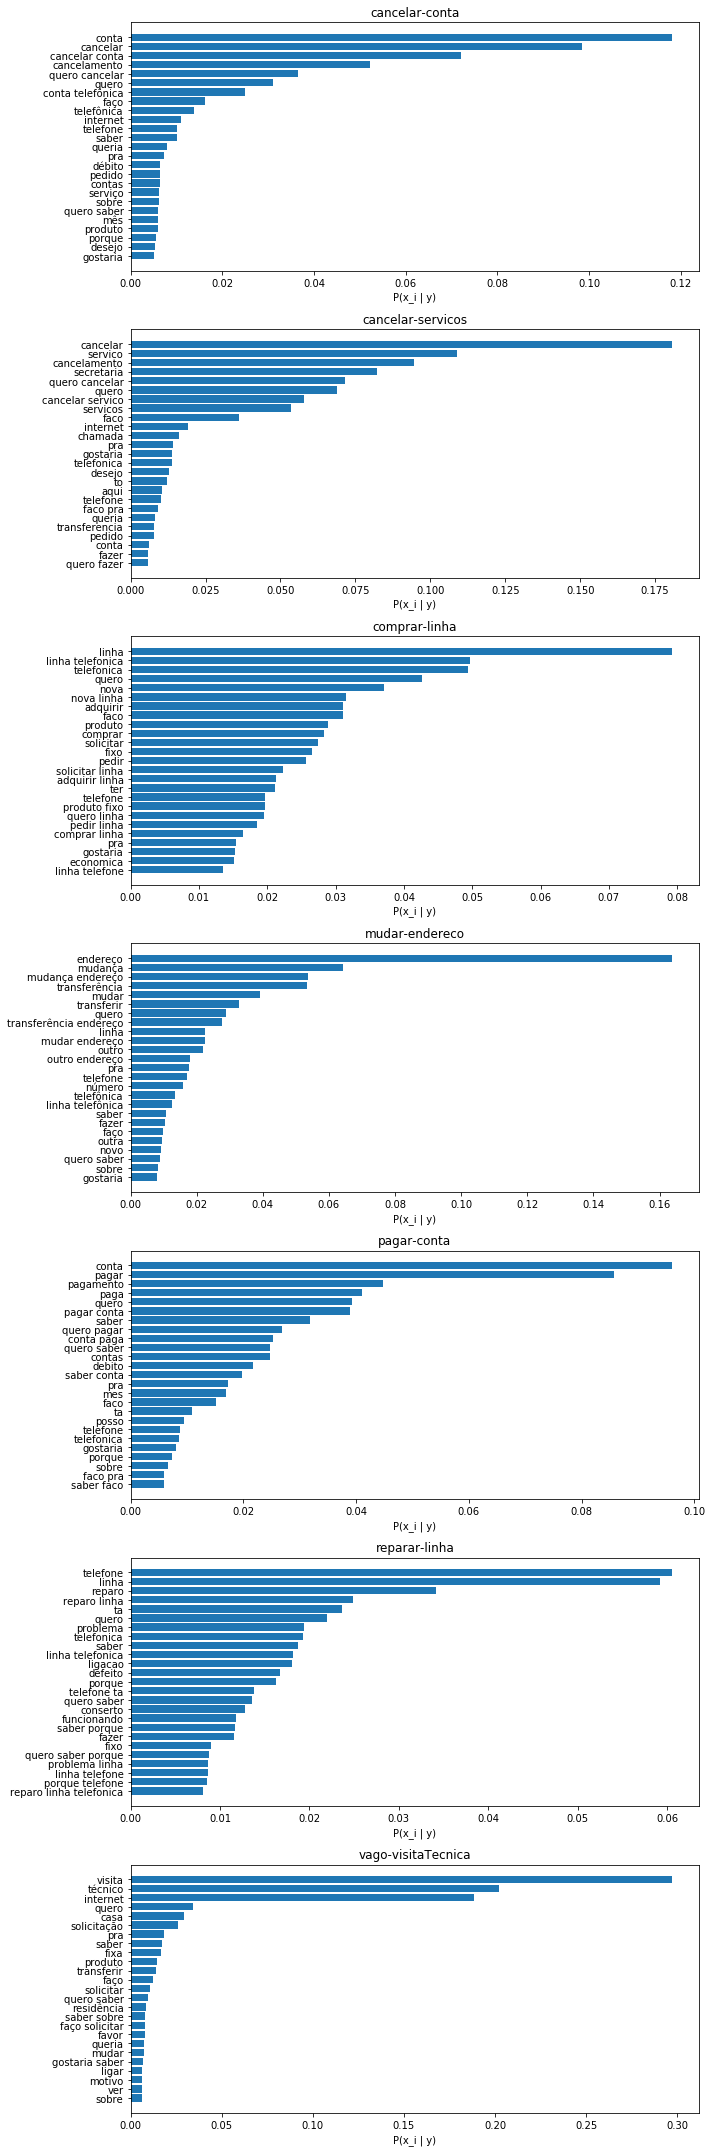

In [29]:
# Plota as verossimilhanças dos principais n-gramas para cada classificador.
fig, ax = plt.subplots(num_class, 1)
fig.set_figwidth(10)
fig.set_figheight(30)
for label, gscv in gscv_dict.items():
    j = encoder.transform([label])[0]
    vocab = gscv.best_estimator_.named_steps['tfidf'].vocabulary_
    ngram_log_probas = gscv.best_estimator_.named_steps['clf'].feature_log_prob_
    plot_ngram_likelihoods(ax[j], label, vocab, ngram_log_probas[1, :])
plt.tight_layout()

In [30]:
# Prevê as probabilidades de cada classe no conjunto de teste.
y_proba = np.empty((y_test.shape[0], num_class))
for label, gscv in gscv_dict.items():
    j = encoder.transform([label])[0]
    y_proba[:, j] = gscv.best_estimator_.predict_proba(X_test)[:, 1]
y_proba

array([[2.88134547e-02, 9.52843162e-02, 2.06840210e-01, ...,
        8.33156017e-02, 4.73354725e-01, 8.34707946e-03],
       [9.42623302e-03, 1.81238449e-21, 2.63373954e-22, ...,
        8.35079544e-03, 1.00000000e+00, 2.32306637e-23],
       [4.23838306e-03, 1.97619660e-10, 7.30212925e-11, ...,
        9.42026583e-03, 9.94035758e-01, 2.80041793e-19],
       ...,
       [1.07870325e-02, 2.49078999e-15, 1.17265578e-15, ...,
        1.15467887e-02, 9.99999999e-01, 1.65453163e-17],
       [7.04643925e-03, 1.13926926e-21, 9.98323876e-01, ...,
        5.54306948e-03, 2.45723268e-03, 5.57330811e-21],
       [5.12261284e-04, 5.01894596e-17, 9.74851823e-17, ...,
        4.48262136e-04, 1.00000000e+00, 1.18522147e-16]])

In [31]:
# Calcula a curva ROC para cada classificador no conjunto de teste.
fpr = [None] * num_class
tpr = [None] * num_class
roc_thresh = [None] * num_class
roc_auc = [None] * num_class
for label in gscv_dict:
    j = encoder.transform([label])[0]
    fpr[j], tpr[j], roc_thresh[j] = roc_curve(y_test[:, j], y_proba[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

In [32]:
# Calcula a curva PR para cada classificador no conjunto de teste.
precision = [None] * num_class
recall = [None] * num_class
pr_thresh = [None] * num_class
for label in gscv_dict:
    j = encoder.transform([label])[0]
    precision[j], recall[j], pr_thresh[j] = precision_recall_curve(
        y_test[:, j], y_proba[:, j])

In [33]:
# Função que plota as curva ROC e PR de um classificador.
def plot_roc_pr_curves(ax, label, fpr, tpr, precision, recall):
    ax[0].plot(fpr, tpr, lw=2, label='Curva ROC')
    ax[0].plot([0, 1], [0, 1], color='salmon', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')
    ax[0].set_title(label)
    ax[0].legend(loc='lower right')
    
    ax[1].plot(precision, recall, lw=2, label='Curva PR')
    ax[1].plot([0, 1], [1, 0], color='salmon', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Precision')
    ax[1].set_ylabel('Recall')
    ax[1].set_title(label)
    ax[1].legend(loc='lower left')

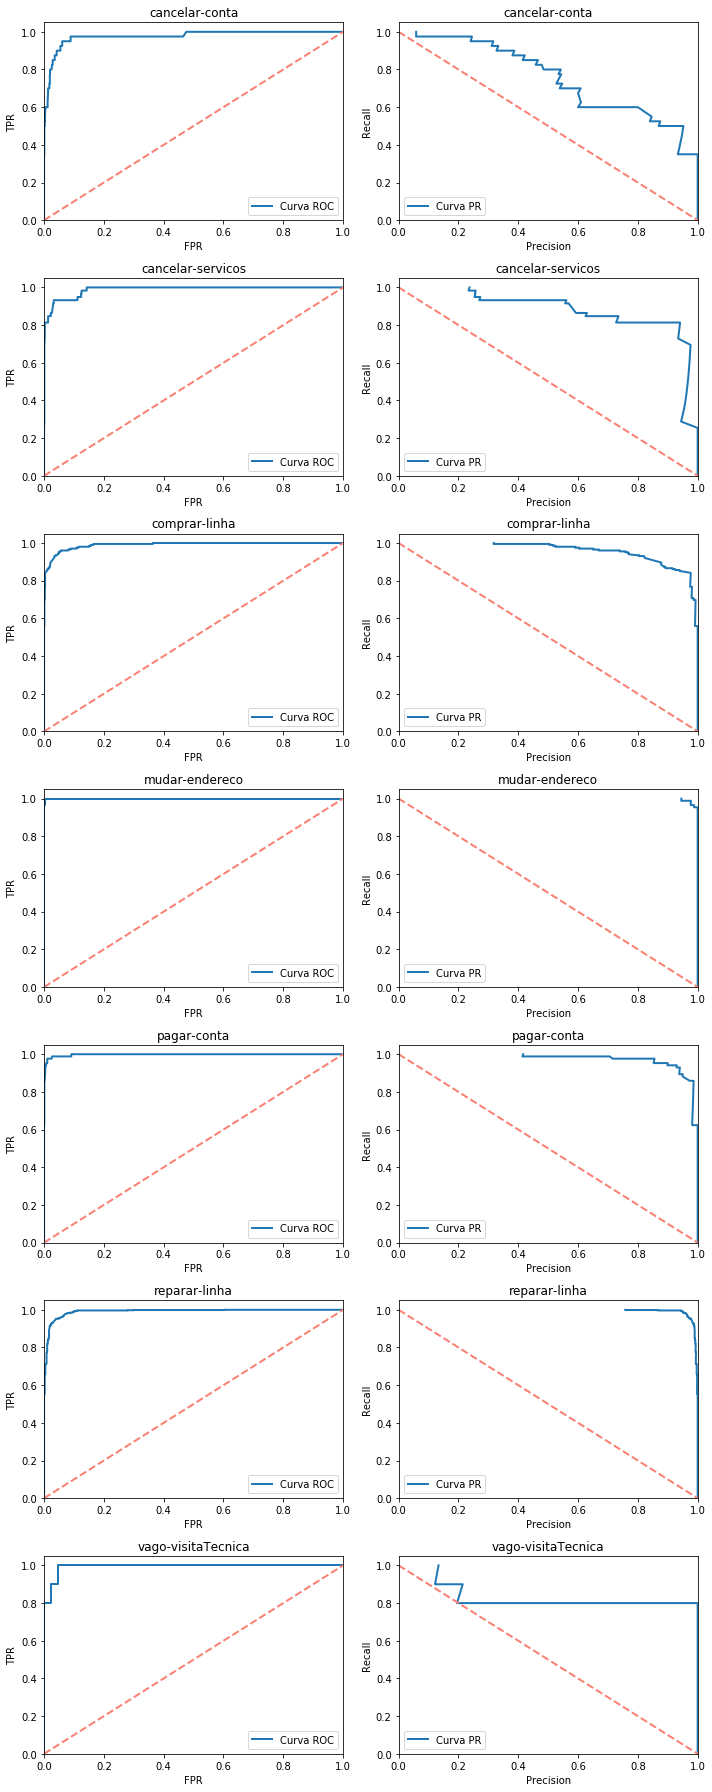

In [34]:
# Plota as curvas ROC e PR de cada classificador para o conjunto de teste.
fig, ax = plt.subplots(num_class, 2)
fig.set_figwidth(10)
fig.set_figheight(25)
for label in gscv_dict:
    j = encoder.transform([label])[0]
    plot_roc_pr_curves(ax[j, :], label, fpr[j], tpr[j], precision[j], recall[j])
plt.tight_layout()

In [35]:
# # Função que acha o ponto de corte ótimo de um classificador pela
# # curva ROC, maximizando a soma de sensibilidade + especificidade.
# def roc_find_best_thresh(thresh, fpr, tpr):
#     best_thresh_ind = -1
#     max_ss_sum = -1.0
#     for i in range(len(thresh)):
#         ss_sum = tpr[i] + (1.0 - fpr[i])
#         if ss_sum > max_ss_sum:
#             max_ss_sum = ss_sum
#             best_thresh_ind = i
#     return best_thresh_ind

In [36]:
# # Identifica o ponto de corte ótimo em cada classificador
# # pela curva ROC.
# roc_best_thresh_ind = [None] * num_class
# roc_best_thresh = np.empty((7,))
# for label in gscv_dict:
#     j = encoder.transform([label])[0]
#     roc_best_thresh_ind[j] = roc_find_best_thresh(roc_thresh[j], fpr[j], tpr[j])
#     roc_best_thresh[j] = roc_thresh[j][roc_best_thresh_ind[j]]
#     best_fpr = fpr[j][roc_best_thresh_ind[j]]
#     best_tpr = tpr[j][roc_best_thresh_ind[j]]
#     print('{} ==> roc_thresh: {}; fpr: {}; tpr: {}'.format(
#         label, roc_best_thresh[j], best_fpr, best_tpr))

In [37]:
# Função que acha o ponto de corte ótimo de um classificador pela
# curva PR, maximizando o F1-score.
def pr_find_best_thresh(thresh, precision, recall):
    best_thresh_ind = -1
    max_f1 = -1.0
    for i in range(len(thresh)):
        f1 = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
        if f1 > max_f1:
            max_f1 = f1
            best_thresh_ind = i
    return best_thresh_ind

In [38]:
# Identifica o ponto de corte ótimo em cada classificador
# pela curva PR.
pr_best_thresh_ind = [None] * num_class
pr_best_thresh = np.empty((7,))
for label in gscv_dict:
    j = encoder.transform([label])[0]
    pr_best_thresh_ind[j] = pr_find_best_thresh(pr_thresh[j], precision[j], recall[j])
    pr_best_thresh[j] = pr_thresh[j][pr_best_thresh_ind[j]]
    best_precision = precision[j][pr_best_thresh_ind[j]]
    best_recall = recall[j][pr_best_thresh_ind[j]]
    print('{} ==> pr_thresh: {}; precision: {}; recall: {}'.format(
        label, pr_best_thresh[j], best_precision, best_recall))

cancelar-conta ==> pr_thresh: 0.3094001777928249; precision: 0.8; recall: 0.6
cancelar-servicos ==> pr_thresh: 0.5924471025016173; precision: 0.9411764705882353; recall: 0.8135593220338984
comprar-linha ==> pr_thresh: 0.45890510371614085; precision: 0.9770114942528736; recall: 0.8415841584158416
mudar-endereco ==> pr_thresh: 0.2724024873489255; precision: 0.9772727272727273; recall: 0.9885057471264368
pagar-conta ==> pr_thresh: 0.26526131082446036; precision: 0.9302325581395349; recall: 0.9411764705882353
reparar-linha ==> pr_thresh: 0.5428434208955388; precision: 0.9602150537634409; recall: 0.9823982398239824
vago-visitaTecnica ==> pr_thresh: 0.6149971293950048; precision: 1.0; recall: 0.8


In [39]:
# Realiza previsões no conjunto de teste utilizando os pontos
# de corte ótimos previamente identificados.
y_pred = np.empty((y_test.shape[0], num_class))
for label in gscv_dict:
    j = encoder.transform([label])[0]
    y_pred[:, j] = (y_proba[:, j] > pr_best_thresh[j]).astype(int)
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [40]:
# Exibe os resultados para cada classificador no conjunto de teste.
# A matriz deverá ser interpretada da seguinte maneira:
# [ VN | FP ] AN
# [ FN | VP ] AP
#   PN   PP
for label in gscv_dict:
    j = encoder.transform([label])[0]
    print('=====================================================')
    print(label)
    print(confusion_matrix(y_test[:, j], y_pred[:, j]))
    print(classification_report(y_test[:, j], y_pred[:, j]))
    print('roc auc\t{}'.format(roc_auc_score(y_test[:, j], y_pred[:, j])))
    print()

cancelar-conta
[[1348    4]
 [  18   22]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1352
           1       0.85      0.55      0.67        40

   micro avg       0.98      0.98      0.98      1392
   macro avg       0.92      0.77      0.83      1392
weighted avg       0.98      0.98      0.98      1392

roc auc	0.7735207100591716

cancelar-servicos
[[1330    3]
 [  12   47]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1333
           1       0.94      0.80      0.86        59

   micro avg       0.99      0.99      0.99      1392
   macro avg       0.97      0.90      0.93      1392
weighted avg       0.99      0.99      0.99      1392

roc auc	0.8971798034254327

comprar-linha
[[1186    4]
 [  33  169]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1190
           1       0.98      0.84      0.90       202

In [41]:
# Salva os modelos e seus pontos de corte ótimos em disco.
# O objeto salvo é um dicionário Python.
for label, gscv in gscv_dict.items():
    j = encoder.transform([label])[0]
    algorithm = gscv.best_estimator_.named_steps['clf'].__class__.__name__
    filename = '{}__{}'.format(algorithm, label)
    obj = {'name': filename,
           'model': gscv.best_estimator_,
           'threshold': pr_best_thresh[j]}
    with open(os.path.join(models_dir, obj['name']), mode='wb') as f:
        pickle.dump(obj, f)

In [42]:
# Carrega os modelos salvos do disco para conferir se está tudo ok.
for label in gscv_dict:
    algorithm = gscv.best_estimator_.named_steps['clf'].__class__.__name__
    filename = '{}__{}'.format(algorithm, label)
    with open(os.path.join(models_dir, filename), mode='rb') as f:
        obj = pickle.load(f)
        print(obj)

{'name': 'MultinomialNB__cancelar-conta', 'model': Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.005,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=T...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]), 'threshold': 0.3094001777928249}
{'name': 'MultinomialNB__cancelar-servicos', 'model': Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.005,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=T...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True))

In [43]:
# Organiza todas as previsões em um DataFrame.
results_dict = {'frase': X_test, 'tag': y_test_backup}
for label, gscv in gscv_dict.items():
    j = encoder.transform([label])[0]
    results_dict[label] = y_pred[:, j]
df_train_results = pd.DataFrame(results_dict)
df_train_results.head(10)

,frase,tag,cancelar-conta,cancelar-servicos,comprar-linha,mudar-endereco,pagar-conta,reparar-linha,vago-visitaTecnica
1857,quero virar cliente,comprar-linha,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1516,não está funcionando só tá dando ocupado,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6711,porque o meu telefone esta fora da área,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5141,estou sem linha de telefone,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1418,pedir o produto fixo,comprar-linha,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2739,quero saber porque minha linha não funciona,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1342,quero transferir o endereço da minha linha,mudar-endereco,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3168,reparo do meu produto fixo,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3588,eu gostaria de saber porque que a minha linha ...,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5976,manutenção no telefone residencial,reparar-linha,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
# Obs: note que, como os classificadores são independentes, pode
# acontecer de nenhum deles dar uma previsão positiva. Esses casos
# podem também ser dicas de que houve uma mudança na população.

In [45]:
# A partir daqui, seria selecionar as observações que caíram em cada
# previsão e jogar, cada uma, para um novo ciclo de previsões no
# seu classificador correspondente no próximo nível hierárquico...